<a href="https://colab.research.google.com/github/ysleead/comp4211_project/blob/first/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# comp4211 project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import torch
import PIL
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from torchvision import transforms, utils, models
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [0]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ColorJitter(0.02,0.02,0.02,0.02),
     transforms.RandomResizedCrop(size = 512, scale = (0.6,1.0)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_transform = transforms.Compose(
    [transforms.Resize(600),
     transforms.CenterCrop(512),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


class imgDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        df = pd.read_csv(csv_file)
        self.df = df
        self.root_dir = root_dir
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.root_dir+'/'+str(self.df.iloc[idx,0])+'.jpg'
        X = PIL.Image.open(img_name).convert('RGB')
        y = torch.tensor(self.df.iloc[idx,1:])
        return X, y

class ApplyTransform(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target
    def __len__(self):
        return len(self.dataset)

In [0]:
torch.manual_seed(1)

#file path from my drive
train_data = imgDataset(csv_file = "/content/drive/My Drive/Colab/COMP4211 Project/train.csv", 
                       root_dir = "/content/drive/My Drive/Colab/COMP4211 Project/images")

train_size = int(0.8 * len(train_data))
valid_size = len(train_data) - train_size

train, valid = random_split(train_data, [train_size, valid_size])
train = ApplyTransform(train, train_transform)
valid = ApplyTransform(valid, valid_transform)

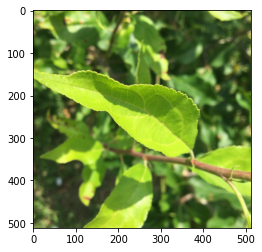

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

imshow(train[0][0])

In [0]:
batch_size = 8

train_loader = DataLoader(train, batch_size=batch_size,
                          shuffle=True, num_workers=0)
valid_loader = DataLoader(valid, batch_size=batch_size,
                          shuffle=True, num_workers=0)

In [0]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(save_path, model):
    state_dict = torch.load(save_path)
    best_model = model
    best_model.load_state_dict(state_dict['model_state_dict'])
    print(f'Model loaded from <== {save_path}')
    best_model.eval()
    return best_model

In [0]:
def train_model(model, criterion, optimizer, num_epochs, eval_every, device, save_name):
  global_step = 0
  total_step = len(train_loader) * num_epochs
  running_loss = 0.0
  train_losses = []
  val_losses = []
  best_val_loss = float("Inf")

  for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-------------------")

    for i, (inputs, labels) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      #forward
      outputs = model(inputs)
      loss = criterion(outputs, labels.float())
      #backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      global_step += 1
      running_loss += loss.item()

      if global_step % eval_every == 0:
        with torch.no_grad():
          model.eval()
          val_running_loss = 0.0
          for j, (val_inputs, val_labels) in enumerate(valid_loader):
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels.float())
            val_running_loss += val_loss.item()

          avg_train_loss = running_loss / eval_every
          avg_val_loss = val_running_loss / len(valid_loader)

          train_losses.append(avg_train_loss)
          val_losses.append(avg_val_loss)

          print(f"Step: {global_step}/{total_step}, Avg train loss: {avg_train_loss:.4f}, Avg val loss: {avg_val_loss:.4f}")
          running_loss = 0.0

          if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
  print("Finished training")
  return train_losses, val_losses
          

In [0]:
def eval(model, test_loader, train_losses, val_losses):
  torch.manual_seed(1)
  plt.plot(np.arange(50,910,50),train_losses, label="Training Loss")
  plt.plot(np.arange(50,910,50),val_losses, label="Validation Loss")
  plt.legend()
  plt.xlabel("Steps")
  plt.ylabel("Loss")
  plt.title("Train / Validation loss")
  plt.show()

  y_pred = np.empty((0,4))
  y_label = np.empty((0,4))
  with torch.no_grad():
    for inputs, labels in test_loader:
      model.eval()
      inputs = inputs.to(device)
      outputs = model(inputs)
      y_pred = np.vstack((y_pred, nn.functional.softmax(outputs, dim=1).cpu().numpy()))
      y_label = np.vstack((y_label, labels.cpu().numpy()))
  print('roc auc score:', roc_auc_score(y_label, y_pred, average='macro', multi_class = "ovr"))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(4):
      fpr[i], tpr[i], _ = roc_curve(y_label[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  colors = ['aqua', 'darkorange', 'cornflowerblue', 'pink']
  for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.3f})'
             ''.format(i, roc_auc[i]))

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

In [11]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=539d030da96e4d103ab19cc4d3db16e5eecd9f1a40f5a1aaf273cab8efd1dea0
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=4)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

Loaded pretrained weights for efficientnet-b4


In [0]:
enb4_train_losses, enb4_valid_losses = train_model(model, criterion, optimizer, 5, 50, device, f'enb4.pt')

Epoch 1/5
-------------------
Step: 20/910, Avg train loss: 0.6698, Avg val loss: 0.6890
Model saved to ==> enb4.pt
Step: 40/910, Avg train loss: 0.5540, Avg val loss: 0.3984
Model saved to ==> enb4.pt
Step: 60/910, Avg train loss: 0.3133, Avg val loss: 0.1982
Model saved to ==> enb4.pt
Step: 80/910, Avg train loss: 0.1869, Avg val loss: 0.2105
Step: 100/910, Avg train loss: 0.1814, Avg val loss: 0.1185
Model saved to ==> enb4.pt
Step: 120/910, Avg train loss: 0.1315, Avg val loss: 0.1260
Step: 140/910, Avg train loss: 0.1050, Avg val loss: 0.1072
Model saved to ==> enb4.pt
Step: 160/910, Avg train loss: 0.1157, Avg val loss: 0.1034
Model saved to ==> enb4.pt
Step: 180/910, Avg train loss: 0.1188, Avg val loss: 0.1103
Epoch 2/5
-------------------
Step: 200/910, Avg train loss: 0.0730, Avg val loss: 0.1087
Step: 220/910, Avg train loss: 0.0552, Avg val loss: 0.0897
Model saved to ==> enb4.pt
Step: 240/910, Avg train loss: 0.0721, Avg val loss: 0.0910
Step: 260/910, Avg train loss: 0.09

Model loaded from <== enb4.pt


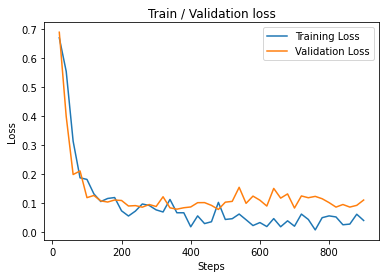

roc auc score: 0.9773345484092507


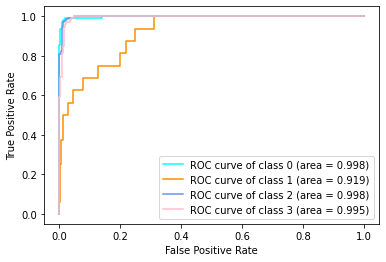

In [0]:
torch.manual_seed(1)
test_loader = DataLoader(valid, batch_size=batch_size,
                          shuffle=False, num_workers=0)
best_model = load_checkpoint('enb4.pt',model)
eval(best_model, test_loader, enb4_train_losses, enb4_valid_losses)

In [0]:
import csv
def save_list(mylist, filename):
  with open(filename, 'w', newline='') as myfile:
      wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
      wr.writerow(mylist)

In [0]:
save_list(enb4_train_losses, "enb4_train_losses.csv")
save_list(enb4_valid_losses, "enb4_valid_losses.csv")

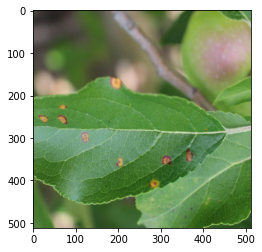

In [24]:
torch.manual_seed(random.randint(0,4211))
train_data = imgDataset(csv_file = "/content/drive/My Drive/Colab/COMP4211 Project/train.csv", 
                       root_dir = "/content/drive/My Drive/Colab/COMP4211 Project/images")

train_size = int(0.8 * len(train_data))
valid_size = len(train_data) - train_size

train, valid = random_split(train_data, [train_size, valid_size])
train = ApplyTransform(train, train_transform)
valid = ApplyTransform(valid, valid_transform)
imshow(train[0][0])

Loaded pretrained weights for efficientnet-b4
learning rate = 9.845672282607728e-05
Epoch 1/5
-------------------
Step: 50/910, Avg train loss: 0.5759, Avg val loss: 0.5225
Model saved to ==> enb40.pt
Step: 100/910, Avg train loss: 0.1884, Avg val loss: 0.1628
Model saved to ==> enb40.pt
Step: 150/910, Avg train loss: 0.1249, Avg val loss: 0.1182
Model saved to ==> enb40.pt
Epoch 2/5
-------------------
Step: 200/910, Avg train loss: 0.0861, Avg val loss: 0.1101
Model saved to ==> enb40.pt
Step: 250/910, Avg train loss: 0.0968, Avg val loss: 0.1826
Step: 300/910, Avg train loss: 0.0835, Avg val loss: 0.1657
Step: 350/910, Avg train loss: 0.0960, Avg val loss: 0.0772
Model saved to ==> enb40.pt
Epoch 3/5
-------------------
Step: 400/910, Avg train loss: 0.0654, Avg val loss: 0.1236
Step: 450/910, Avg train loss: 0.0608, Avg val loss: 0.1004
Step: 500/910, Avg train loss: 0.0515, Avg val loss: 0.0970
Epoch 4/5
-------------------
Step: 550/910, Avg train loss: 0.0493, Avg val loss: 0.09

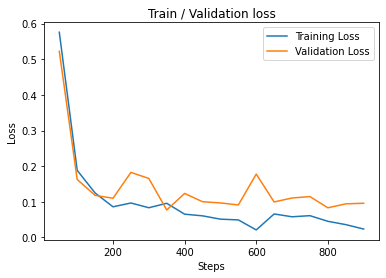

roc auc score: 0.9840416238467904


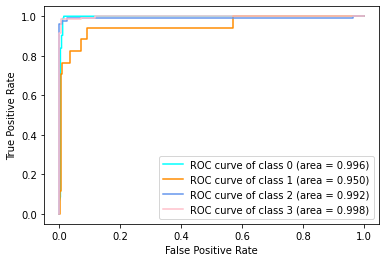

Loaded pretrained weights for efficientnet-b4
learning rate = 1.5464095481563678e-05
Epoch 1/5
-------------------
Step: 50/910, Avg train loss: 0.6774, Avg val loss: 0.6928
Model saved to ==> enb41.pt
Step: 100/910, Avg train loss: 0.5485, Avg val loss: 0.4247
Model saved to ==> enb41.pt
Step: 150/910, Avg train loss: 0.2944, Avg val loss: 0.1903
Model saved to ==> enb41.pt
Epoch 2/5
-------------------
Step: 200/910, Avg train loss: 0.1709, Avg val loss: 0.1316
Model saved to ==> enb41.pt
Step: 250/910, Avg train loss: 0.1158, Avg val loss: 0.1203
Model saved to ==> enb41.pt
Step: 300/910, Avg train loss: 0.1001, Avg val loss: 0.1268
Step: 350/910, Avg train loss: 0.1034, Avg val loss: 0.1059
Model saved to ==> enb41.pt
Epoch 3/5
-------------------
Step: 400/910, Avg train loss: 0.0859, Avg val loss: 0.1258
Step: 450/910, Avg train loss: 0.0651, Avg val loss: 0.0994
Model saved to ==> enb41.pt
Step: 500/910, Avg train loss: 0.0653, Avg val loss: 0.0991
Model saved to ==> enb41.pt
Ep

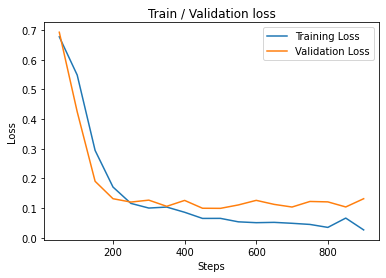

roc auc score: 0.9887710838415069


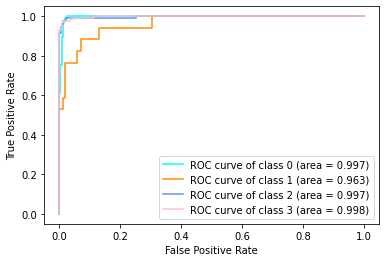

Loaded pretrained weights for efficientnet-b4
learning rate = 7.013407130196256e-05
Epoch 1/5
-------------------
Step: 50/910, Avg train loss: 0.6195, Avg val loss: 0.6310
Model saved to ==> enb42.pt
Step: 100/910, Avg train loss: 0.2106, Avg val loss: 0.1477
Model saved to ==> enb42.pt
Step: 150/910, Avg train loss: 0.1394, Avg val loss: 0.1188
Model saved to ==> enb42.pt
Epoch 2/5
-------------------
Step: 200/910, Avg train loss: 0.1057, Avg val loss: 0.1087
Model saved to ==> enb42.pt
Step: 250/910, Avg train loss: 0.0942, Avg val loss: 0.1031
Model saved to ==> enb42.pt
Step: 300/910, Avg train loss: 0.0607, Avg val loss: 0.1023
Model saved to ==> enb42.pt
Step: 350/910, Avg train loss: 0.0849, Avg val loss: 0.1000
Model saved to ==> enb42.pt
Epoch 3/5
-------------------
Step: 400/910, Avg train loss: 0.0618, Avg val loss: 0.0951
Model saved to ==> enb42.pt
Step: 450/910, Avg train loss: 0.0370, Avg val loss: 0.1063
Step: 500/910, Avg train loss: 0.0608, Avg val loss: 0.0862
Mod

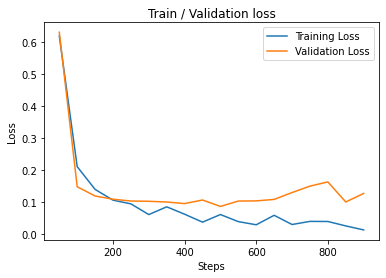

roc auc score: 0.9921627816280558


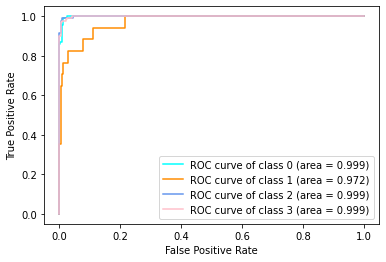

Loaded pretrained weights for efficientnet-b4
learning rate = 1.017852318720085e-05
Epoch 1/5
-------------------
Step: 50/910, Avg train loss: 0.6820, Avg val loss: 0.6925
Model saved to ==> enb43.pt
Step: 100/910, Avg train loss: 0.5997, Avg val loss: 0.5039
Model saved to ==> enb43.pt
Step: 150/910, Avg train loss: 0.4307, Avg val loss: 0.3599
Model saved to ==> enb43.pt
Epoch 2/5
-------------------
Step: 200/910, Avg train loss: 0.2912, Avg val loss: 0.2007
Model saved to ==> enb43.pt
Step: 250/910, Avg train loss: 0.1548, Avg val loss: 0.1420
Model saved to ==> enb43.pt
Step: 300/910, Avg train loss: 0.1159, Avg val loss: 0.1406
Model saved to ==> enb43.pt
Step: 350/910, Avg train loss: 0.1084, Avg val loss: 0.1213
Model saved to ==> enb43.pt
Epoch 3/5
-------------------
Step: 400/910, Avg train loss: 0.0977, Avg val loss: 0.1153
Model saved to ==> enb43.pt
Step: 450/910, Avg train loss: 0.0777, Avg val loss: 0.1155
Step: 500/910, Avg train loss: 0.0897, Avg val loss: 0.1077
Mod

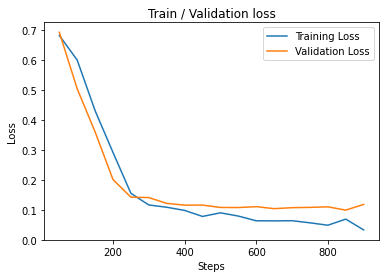

roc auc score: 0.9887140661448166


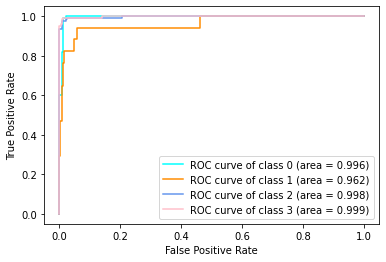

Loaded pretrained weights for efficientnet-b4
learning rate = 3.478280427746788e-05
Epoch 1/5
-------------------
Step: 50/910, Avg train loss: 0.6593, Avg val loss: 0.6905
Model saved to ==> enb44.pt
Step: 100/910, Avg train loss: 0.3486, Avg val loss: 0.2046
Model saved to ==> enb44.pt
Step: 150/910, Avg train loss: 0.1448, Avg val loss: 0.1227
Model saved to ==> enb44.pt
Epoch 2/5
-------------------
Step: 200/910, Avg train loss: 0.1002, Avg val loss: 0.1057
Model saved to ==> enb44.pt
Step: 250/910, Avg train loss: 0.0868, Avg val loss: 0.1044
Model saved to ==> enb44.pt
Step: 300/910, Avg train loss: 0.0702, Avg val loss: 0.1017
Model saved to ==> enb44.pt
Step: 350/910, Avg train loss: 0.0919, Avg val loss: 0.0901
Model saved to ==> enb44.pt
Epoch 3/5
-------------------
Step: 400/910, Avg train loss: 0.0571, Avg val loss: 0.1110
Step: 450/910, Avg train loss: 0.0487, Avg val loss: 0.0942
Step: 500/910, Avg train loss: 0.0565, Avg val loss: 0.0970
Epoch 4/5
-------------------
S

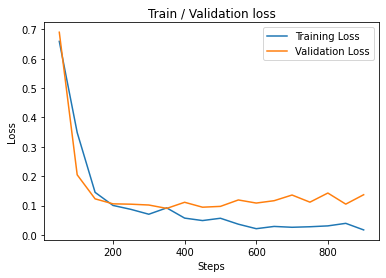

roc auc score: 0.9886385973960528


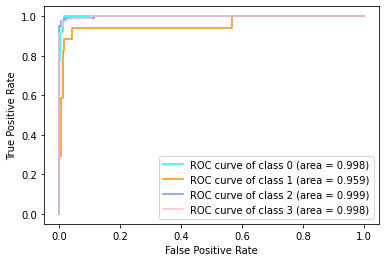

In [29]:
train_losses = dict()
valid_losses = dict()
for i in range(5):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=4)
  model = model.to(device)
  criterion = nn.BCEWithLogitsLoss()
  lr = random.random() * 10 ** -4
  print(f"learning rate = {lr}")
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  train_losses[i], valid_losses[i] = train_model(model, criterion, optimizer, 5, 50, device, f'enb4{i}.pt')
  torch.manual_seed(1)
  test_loader = DataLoader(valid, batch_size=batch_size,
                            shuffle=False, num_workers=0)
  best_model = load_checkpoint(f'enb4{i}.pt',model)
  eval(best_model, test_loader, train_losses[i], valid_losses[i])